# Phase Transition in Molecular Dynamics Simulation

## Authors
[Alexander M. Lohse](https://www.linkedin.com/in/alexander-lohse-7b2a0468), Georgia Tech, MSE

[Ross J. Verploegh](https://www.linkedin.com/in/rossverploegh), Georgia Tech, ChBE

## Introduction

Classical molecular mechanics (MM) is a powerful tool in materials engineering.  Some examples where molecular dynamics (MD) has been applied include large simulations of protein folding for drug design, diffusion of gas molecules through organic/inorganic nanoporous materials, and phase separation of polymers.  Sometimes, however, analyzing the trajectory data (e.g. atom types and atomic coordinates) with respect to some 1-D observable, such as geometric distances or density, does not capture all the important information.  The tools within PyMKS allow for analysis of MD trajectory data in an unbiased way.

This example uses `MKSStructureAnalysis` to look at loading-induced thermodynamic transition of a metal organic framework (ZIF-8) from low to high loading configurations.  This example is particularly interesting because it is not clear what 1-D or 2-D reaction coordinate could be used to describe this transition.   



## Molecular Dynamics Simulation of a Thermodynamic Phase Transition

A molecular dynamics simulation was performed using [LAMMPS Molecular Dynamics Simulator](http://lammps.sandia.gov/).  The flexible ZIF-8 framework and nitrogen gas molecules were described using the force fields described in [this manuscript](https://dx.doi.org/10.1021/ja401129h) [1].  For those familiar with the details of MD simulations, this simulation was performed in the NVT-ensemble with a 1.0 femtosecond timestep.  The simulation was run for a total of 35 picoseconds with snapshots taken every 15 femtoseconds (total snapshots in trajectory: 2332). 

## Data Generation: Mapping MD Data to a Grid

For use within PyMKS, atomic data needs to be mapped to a 2-D or 3-D grid such that 2-point statistics can be calculated.

For our example, only the hydrogen coordinates from the ZIF-8 framework are mapped to a fixed 70x70x70 voxel 3-D grid, with a resolution of 0.5 A.  For ZIF-8, there are hydrogens in two types of chemical environments: methyl-group hydrogens and those on the imidazole ring.  Each grid space is either assigned a 0 (void space=no hydrogen), a 1 (filled by a methyl hydrogen), or a 2 (filled by an imidazole hydrogen).  The 3-D grid is then mapped into a 2-D array by summing in the z-direction for visual purposes only; the following analysis of this data could have been applied to the full 3-D data as well.

The below cells just loads the necessary extensions to python for plotting (MatPlotLib) and numerical analysis (NumPy). The data is loaded from a Georgia Tech server.

In [1]:
import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


In [2]:
from pymks_share import DataManager


manager = DataManager('pymks.me.gatech.edu')


In [3]:
X = manager.fetch_data('Molecular Dynamics')


As mentioned, there are 2332 snapshots at 15 femtosecond time intervals on a 70 x 70 pixel 2-D grid.

In [4]:
print X.shape


(2332, 70, 70)


We can draw what the structures look like with draw_microstructures. From left to right the structure is changing as the system goes through a phase transition. Do you notice a difference?

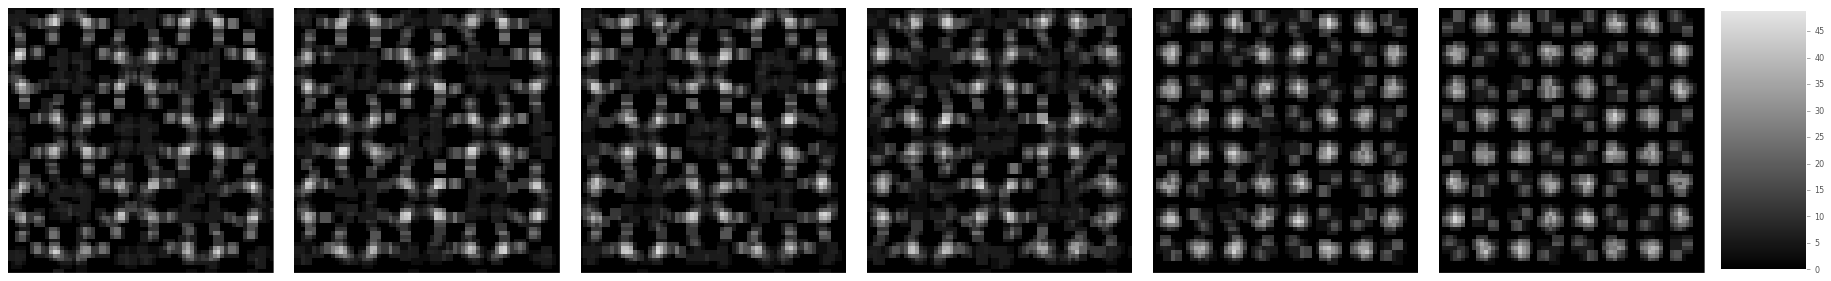

In [5]:
from pymks.tools import draw_microstructures
sample_size = 10
X_examples = X[::sample_size]
time = np.arange(X_examples.shape[0])[:] * sample_size * 15

draw_microstructures((X_examples[::40]))


## Setup the model

Now that we have microstructures we use `MKSStructureAnalysis`.  We use the `PrimitiveBasis` because we will only have two states, voxel with Hydrogen or a voxel with no Hydrogen. Our data domain ranges from 0 to 255 corresponding to the grayscale (0 is black, 255 is white) as seen in the microstructures drawn above). Basically, we are reducing this from 255 (grayscale) states to a probability between 0 and 1. The statistics are then run on this basis we pass to `MKSStructureAnalysis`. As printed in the output, we are doing an autocorrelation from Hydrogen to Hydrogen (1,1) and a cross-correlation from Hydrogen to Void-Space (1,0). Change the corelations and rerun to see how the PCA plots further down change. Especially, note the increase in variance of PC1 with the addition of the (0,0) correlation.

In [6]:
from pymks import MKSStructureAnalysis, PrimitiveBasis
from sklearn.decomposition import RandomizedPCA


prim_basis = PrimitiveBasis(2, domain=[0, 255])
analysis = MKSStructureAnalysis(basis=prim_basis,correlations=[(1, 1)],
                                store_correlations=True, periodic_axes=[0,1])
analysis.correlations


[(1, 1)]

## Polynomial Order

Now that our model is setup we can calculate the statistics and regression with `analysis.fit`. Here we fit the model built above with a subset of our data, `X_examples`. We graph the variance versus the number of components in our PCA model. By default the `PrimitiveBasis` uses a polynomial degree of one.

In [7]:
analysis.n_components = 40
analysis.fit(X_examples)


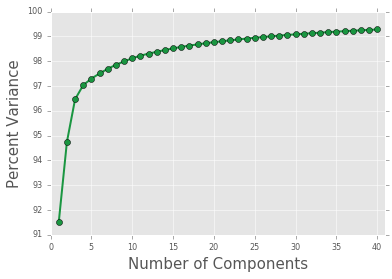

In [8]:
from pymks.tools import draw_component_variance


draw_component_variance(analysis.dimension_reducer.explained_variance_ratio_)


Thee graph above shows that over 92% of the statistics are captured with just 2 components.

## Plotting components

We now can plot the principle components versus time. We see a distinct correlation beteen PC1 and PC2 and note that PC1 is correlated with time. This likely indicates the time of the phase transition in the simulation. We could next try plotting PC1 vs. various geometric order parameters to see if PC1 (or any other principal component) relates.

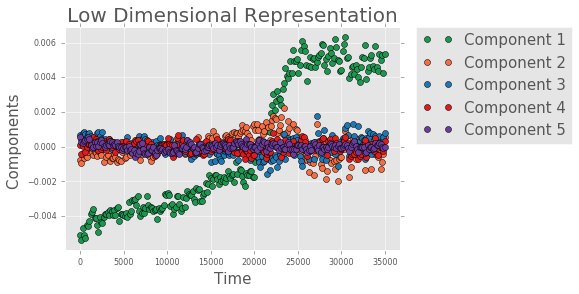

In [9]:
from pymks.tools import draw_components_scatter
from pymks.tools import draw_evolution


analysis.fit(X_examples)
pcs_5 = analysis.reduced_fit_data[:, :5].T.reshape((-1))
times_5 = np.tile(time, 5)

results = np.concatenate((times_5[:, None], pcs_5[:, None]), axis=1)

labels = ['Component 1', 'Component 2',
          'Component 3', 'Component 4', 'Component 5']
draw_evolution(np.array_split(results, 5), labels, legend_outside=True)


Here we plot the first 3 principal components and note two general clusterings. This view captures roughly 95% of the variance in our data.

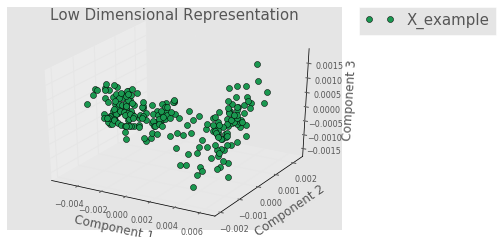

In [10]:
draw_components_scatter([analysis.reduced_fit_data[:, :3]],
                        ['X_example'], legend_outside=True)


Let's take a look at the two point statistics. We look at the images for principal components 1-4. Each image is the correlation for (1,1), or the Hydrogen probability.  

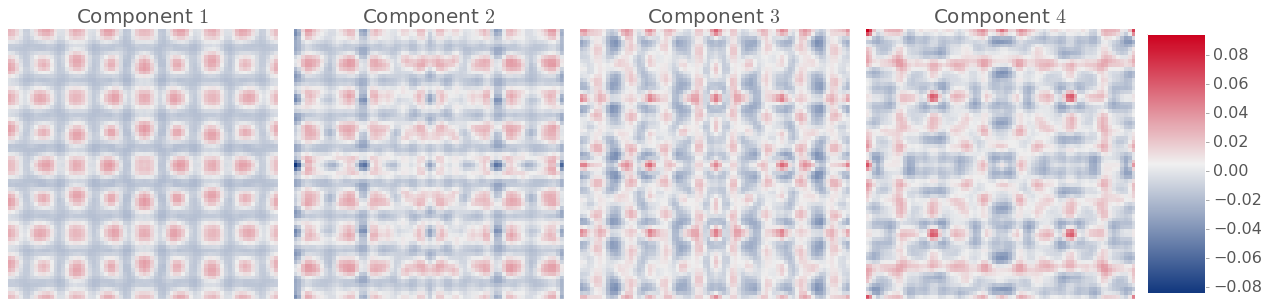

In [11]:
from pymks.tools import draw_correlations
from pymks.tools import draw_components


pcs = analysis.components_
draw_components(pcs[:4], fontsize=20)


Sweet, the pictures are pretty. Now it's time to try and figure out if they mean anything...TBD.

## References

[1] Zhang, Liling, Zhongqiao Hu, and Jianwen Jiang. "Sorption-induced structural transition of zeolitic imidazolate framework-8: a hybrid molecular simulation study." Journal of the American Chemical Society 135.9 (2013): 3722-3728.[doi:10.1021/ja401129h](https://dx.doi.org/10.1021/ja401129h)

[2] Kalidindi, Surya R., et al. "Application of data science tools to quantify and distinguish between structures and models in molecular dynamics datasets." Nanotechnology 26.34 (2015): 344006. [doi:10.1088/0957-4484/26/34/344006](http://dx.doi.org/10.1088/0957-4484/26/34/344006)